In [55]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [56]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/25h9/s_yaw_25h9_5m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [45]

In [57]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [58]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,-23.304382
1,0.058207,15.918931
2,0.242795,16.921554
3,24.848468,-43.338784
4,24.879860,37.202102
...,...,...
464,55.148509,40.698199
465,55.181345,40.527192
466,55.214942,40.698037
467,55.348225,48.071177


<AxesSubplot:xlabel='relative_time'>

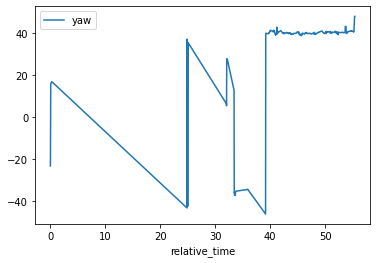

In [59]:
# initial graph
df.plot(x='relative_time', y=target)

In [60]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [61]:
# the amount of data points we are left with
len(x[peaks])

76

In [62]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

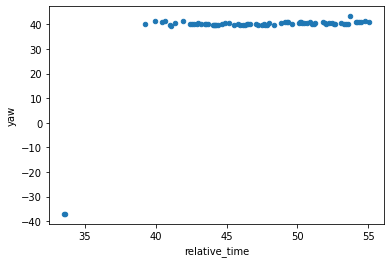

In [63]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [64]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
26,33.548014,-37.013856,45
28,33.613965,-37.044464,45
37,39.247734,40.055964,45
45,39.980024,41.437497,45
55,40.413507,41.070873,45
...,...,...,...
437,54.214489,40.842563,45
440,54.348395,40.909060,45
444,54.481143,40.993388,45
452,54.747975,41.254975,45


In [65]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [66]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [67]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [68]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
37,39.247734,40.055964,45,4.944036
45,39.980024,41.437497,45,3.562503


In [69]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
45,74.0,4.583261,0.578326,1.701269,4.226865,4.65575,4.985615,5.517174


In [70]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name)
        axes.set_title(val)


    plt.tight_layout()
    plt.show()

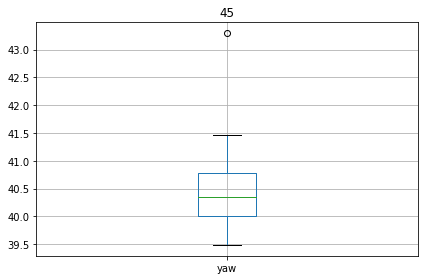

In [71]:
box_plotter(target)

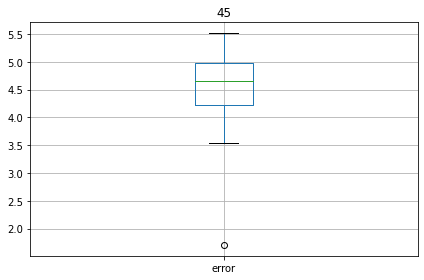

In [72]:
box_plotter('error')